<a href="https://colab.research.google.com/github/sadimanna/hobby_projects/blob/master/ConvLSTM_Test_Copy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Sep 12 10:45:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2080   WDDM  | 00000000:01:00.0  On |                  N/A |
| 33%   48C    P8    34W / 225W |    398MiB /  8192MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [ ]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy, math
from itertools import permutations 
import seaborn as sns
import imageio, io, base64
from skimage.transform import rotate, AffineTransform, warp, resize
#from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image, SVG, Video, HTML
import h5py
import struct as st

#%tensorflow_version 2.x
#%load_ext tensorboard
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, GlobalAveragePooling2D, ConvLSTM2D
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization, Reshape
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Lambda
from tensorflow.keras.activations import relu

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers, activations
from tensorflow.keras.utils import to_categorical, Sequence

from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import model_to_dot

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
#import matplotlib.animation as animation
%matplotlib inline

In [ ]:
#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as ppi_irv2
np.random.seed(16)
tf.random.set_seed(16)


In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input as ppivgg

In [ ]:
pretext_model = VGG16(include_top = False,weights='imagenet', input_shape = (256,256,3))

In [ ]:
x = pretext_model(i)

In [ ]:
x.shape

TensorShape([10, 5, 3, 512])

In [ ]:
inp = Input(shape=(16,8,8,512))

In [ ]:
x = ConvLSTM2D(512,3,padding='same',kernel_initializer = tf.keras.initializers.he_normal(seed=16),return_sequences = True)(inp)
x = ConvLSTM2D(512,3,kernel_initializer = tf.keras.initializers.he_normal(seed=16),return_sequences = False)(x)

In [ ]:
x.shape

TensorShape([None, 6, 6, 512])

In [ ]:
x = GlobalAveragePooling2D()(x)

In [ ]:
x = Dense(512,activation='relu')(x)

In [ ]:
x = Dense(11,activation='softmax')(x)

In [ ]:
dsmodel = Model(inputs = inp,outputs = x,name='ds_model')

In [ ]:
dsmodel.summary()

Model: "ds_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16, 8, 8, 512)]   0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 16, 8, 8, 512)     18876416  
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 6, 6, 512)         18876416  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 11)                5643      
Total params: 38,021,131
Trainable params: 38,021,131
Non-trainable params: 0
______________________________________________

In [ ]:
dsmodel.compile(optimizer=tf.keras.optimizers.RMSprop(0.00001),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = tf.keras.metrics.CategoricalAccuracy())

In [ ]:
tdg = DSDataGen('train',tr_filenames_df, preprocess_input = ppivgg)
vdg = DSDataGen('valid',val_filenames_df,preprocess_input = ppivgg,data_aug= False)

In [ ]:
dshistory = dsmodel.fit(tdg, epochs = 2, validation_data = vdg)

Epoch 1/2
 210/1280 [===>..........................] - ETA: 4:47:53 - loss: 0.2242 - categorical_accuracy: 0.9238

KeyboardInterrupt: 

In [ ]:
results = dsmodel.evaluate(vdg)

320/320 [==============================] - 5777s 18s/step - loss: 0.3821 - categorical_accuracy: 0.8938


In [ ]:
np.mean([92.7,90.62,92.19,91.56,90.62])

91.538

In [ ]:
np.std([92.7,90.62,92.19,91.56,90.62])

0.8320192305469852

In [ ]:
base_path = 'D:\\SiladittyaJRF\\Datasets\\UCF11_updated_mpg'

In [ ]:
classes = os.listdir(base_path)

In [ ]:
filenames_df = pd.DataFrame(columns=['filepath']+classes)

In [ ]:
for c in classes:
    folders = os.listdir('\\'.join([base_path,c]))
    labels = list(map(int,[cl==c for cl in classes]))
    for fol in folders:
        if fol != 'Annotation':
            files = os.listdir('\\'.join([base_path,c,fol]))
            for f in files:
                pathdict = {'filepath':'\\'.join([base_path,c,fol,f])}
                labelsdict = dict(zip(classes,labels))
                filenames_df = filenames_df.append({**pathdict,**labelsdict},ignore_index=True)

In [ ]:
filenames_df = filenames_df.reindex(np.random.permutation(filenames_df.index))

In [ ]:
filenames_df = filenames_df.reset_index()

In [ ]:
filenames_df

,index,filepath,basketball,biking,diving,golf_swing,horse_riding,soccer_juggling,swing,tennis_swing,trampoline_jumping,volleyball_spiking,walking
0,1041,D:\SiladittyaJRF\Datasets\UCF11_updated_mpg\sw...,0,0,0,0,0,0,1,0,0,0,0
1,336,D:\SiladittyaJRF\Datasets\UCF11_updated_mpg\di...,0,0,1,0,0,0,0,0,0,0,0
2,846,D:\SiladittyaJRF\Datasets\UCF11_updated_mpg\so...,0,0,0,0,0,1,0,0,0,0,0
3,511,D:\SiladittyaJRF\Datasets\UCF11_updated_mpg\go...,0,0,0,1,0,0,0,0,0,0,0
4,81,D:\SiladittyaJRF\Datasets\UCF11_updated_mpg\ba...,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,1345,D:\SiladittyaJRF\Datasets\UCF11_updated_mpg\tr...,0,0,0,0,0,0,0,0,1,0,0
1596,581,D:\SiladittyaJRF\Datasets\UCF11_updated_mpg\go...,0,0,0,1,0,0,0,0,0,0,0
1597,121,D:\SiladittyaJRF\Datasets\UCF11_updated_mpg\ba...,1,0,0,0,0,0,0,0,0,0,0
1598,1262,D:\SiladittyaJRF\Datasets\UCF11_updated_mpg\tr...,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
tr_filenames_df, val_filenames_df = train_test_split(filenames_df,test_size = 0.2)

In [ ]:
num_samples_tr = np.sum(tr_filenames_df[classes].values,axis=0)

In [ ]:
sum(num_samples_tr)

1280

In [ ]:
NUM_FRAMES = 16
NUM_CLASSES = 11

In [ ]:
class DSDataGen(Sequence):
    def __init__(self, phase, filenames_df, preprocess_input = None, batch_size=1, data_aug = True, num_frames = NUM_FRAMES, num_classes=NUM_CLASSES):
        self.phase = phase
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.num_classes = num_classes
        self.filenames_df = filenames_df
        self.preprocess_input = preprocess_input
        
        self.MAX_FRAMES = num_frames #NUM_FRAMES

        self.indices = list(range(self.filenames_df.shape[0]))
        
        self.data_aug = data_aug
    
    def load_volume(self,file_idx):
        filePoolLen = self.filenames_df.shape[0]
        #print(file_idx)
        file_idx = file_idx%filePoolLen 
        vol = np.array([]).reshape((0,256,256,3))
        vid = imageio.get_reader(self.filenames_df['filepath'].iloc[file_idx],'ffmpeg')
        for img in vid.iter_data():
            vol = np.append(vol,np.expand_dims(resize(img,(256,256,3),preserve_range=True),axis=0),axis=0)
        return vol
    
    def get_frames(self,idx):
        image_volume = self.load_volume(idx)
        tot_frames = image_volume.shape[0]
        
        self.num_frames = np.min([tot_frames,self.MAX_FRAMES])

        #ONLY FOR STANFORD MODEL
        frame_idxs = np.array(sorted(random.sample(list(range(tot_frames)),self.num_frames)))

        frames = np.array([]).reshape((0,256,256,3))
        for n in range(self.num_frames):
            frame_idx = frame_idxs[n]
            frame = np.array(image_volume[frame_idx])
            frames = np.append(frames,np.expand_dims(frame,axis=0),axis=0)
        #print(frames.shape)
        return frames
    
    def __len__(self):
        return len(self.filenames_df)
    
    def __getitem__(self,idx):
        
        batch_imgs = np.array([]).reshape((0,256,256,3))
        #CREATE BATCH
        for bs in range(self.batch_size):
            #file_idx = self.startind + bs
            #GET CLIP FRAMES
            batch_imgs = np.append(batch_imgs.astype(np.float32),self.get_frames(idx),axis=0)
            
            #sind = 0
            #eind = 0
            #AUGMENT FRAMES
            if self.data_aug and self.phase == 'train':
                batch_imgs = self.__augment(batch_imgs)

        #PREPROCESS FRAMES
        #print(np.min(batch_imgs))
        batch_imgs = self.preprocess_input(batch_imgs)
        inputs = pretext_model(batch_imgs)
        inputs = tf.expand_dims(inputs,axis=0)
        #print(np.min(batch_imgs))
                              
        return inputs, self.filenames_df[classes].iloc[idx].values.astype('int').reshape((1,-1))
    
    def on_epoch_end(self):
        idx = np.random.permutation(self.filenames_df.index.values)
        #self.mllabs = self.mllabs.reindex(idx)
        self.filenames_df = self.filenames_df.reindex(idx)
        #self.mllabs = self.mllabs.reset_index(drop=True)
        self.filenames_df = self.filenames_df.reset_index(drop=True)
    
    def __augment(self,batch_imgs):
        num_imgs = batch_imgs.shape[0]
        rotang = np.random.choice([-20,0,20])
        scale = np.random.choice([1,1.15])
        transformation_matrix=np.array([[scale,           0,             np.random.choice([-15,0,15])],
                                        [0,               scale,         np.random.choice([-15,0,15])],
                                        [0,               0,                       1                 ]])
        for i in range(num_imgs):
            batch_imgs[i] = rotate(batch_imgs[i],rotang,preserve_range=True)
            batch_imgs[i] = warp(batch_imgs[i], AffineTransform(matrix=transformation_matrix).inverse, preserve_range=True)
            #print(batch_labs)
                
        return batch_imgs

In [ ]:
TRDG = DSDataGen('train', tr_filenames_df, preprocess_input = ppivgg, batch_size=1, data_aug = True, num_frames = NUM_FRAMES, num_classes=NUM_CLASSES)

In [ ]:
i,l = TRDG.__getitem__(0)

In [ ]:
i.shape

TensorShape([1, 10, 8, 8, 512])

TypeError: Invalid shape (5, 3, 512) for image data

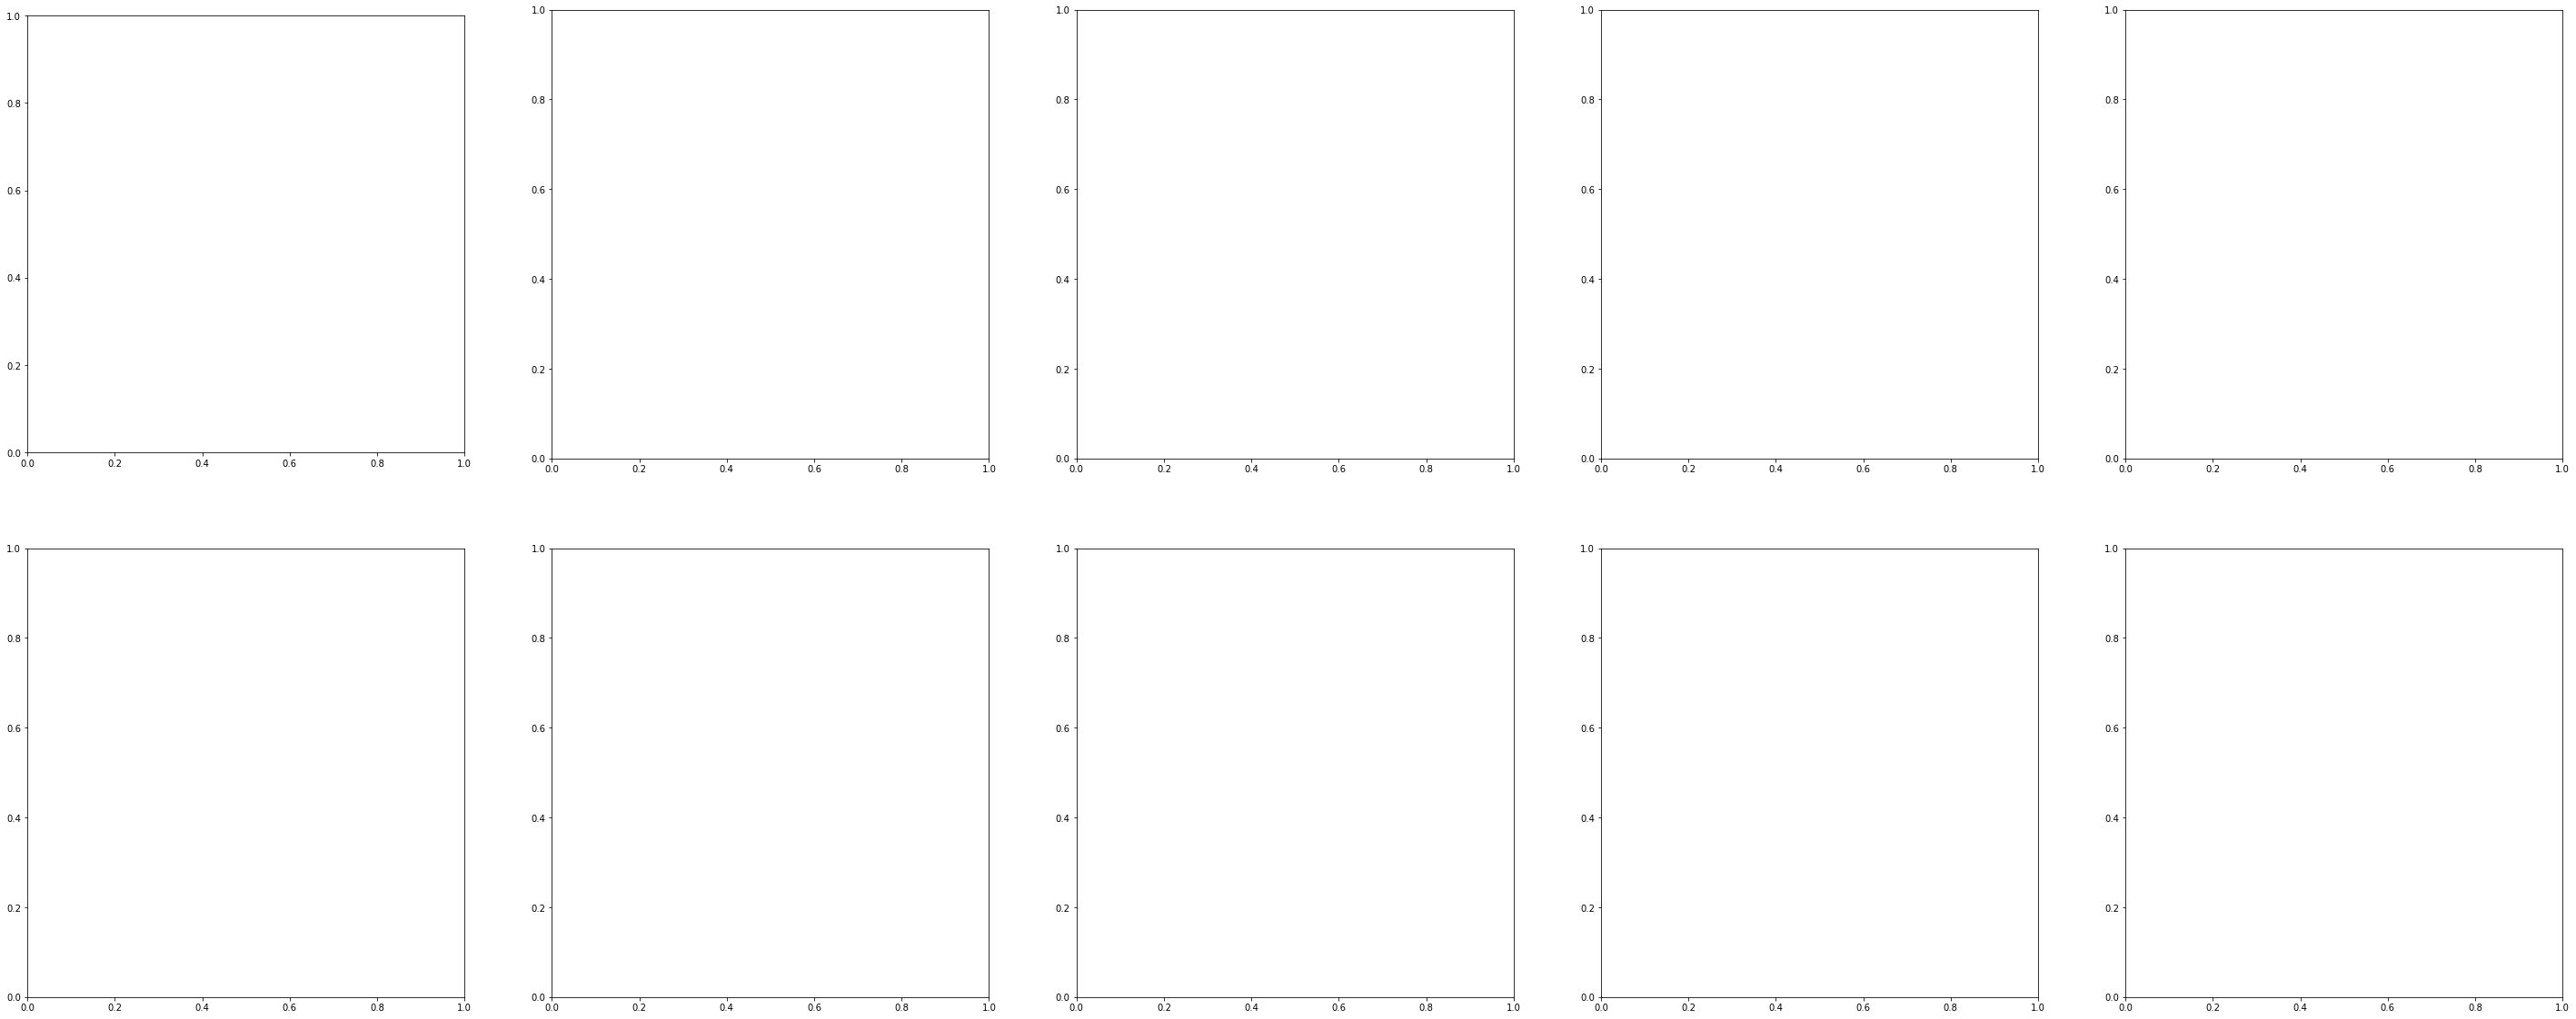

In [ ]:
fig,ax = plt.subplots(2,5,figsize=(50,20))
for j in range(10):
    ax[j//5,j%5].imshow((i[0,j]-np.min(i[0,j]))/(np.max(i[0,j])-np.min(i[0,j])))